# How the Number of Schools in an Area affect Quality of Life

A look at how the number of schools in a UK local authority correlates with other quality of life measures

Sources:

1. Subregional productivity: labour productivity indices by local authority district -  https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/labourproductivity/datasets/subregionalproductivitylabourproductivityindicesbylocalauthoritydistrict

2. Schools, pupils and their characteristics (Phase and type, admissions, denomination, urban-rural, gender) - https://explore-education-statistics.service.gov.uk/data-catalogue/school-pupils-and-their-characteristics/2020-21

3. Income estimates for small areas, England and Wales - https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

4. Recorded crime data by Community Safety Partnership area - https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/recordedcrimedatabycommunitysafetypartnershiparea

5. Regional labour market: Modelled unemployment for local and unitary authorities - https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/datasets/modelledunemploymentforlocalandunitaryauthoritiesm01

6. Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland - https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland

In [109]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [90]:
#read the data in from the schools dataset
school_cols = ["time_period","new_la_code", "number_of_schools", "la_name", "Sex_of_school_description", "Phase-type_grouping", "TypeOfEstablishment_(name)","Denomination", "Admissions_Policy", "Urban_rural","Academy_flag"]
schools = pd.read_csv("spc_school_characteristics_20210727.csv", usecols=school_cols)
schools.rename(columns={"new_la_code":"la_code","Phase-type_grouping": "Phase_Grouping", "TypeOfEstablishment_(name)":"TypeOfEstablishment"}, inplace=True)

#retrieve only totals and 
schools = schools.query("time_period == 202021 &Sex_of_school_description == 'Total' & Phase_Grouping == 'Total' & TypeOfEstablishment == 'Total' & Admissions_Policy == 'Total' & Urban_rural == 'Total' & Academy_flag == 'Total' & Denomination == 'Total'")

#drop any rows with missing data
schools = schools.dropna()

#remove unnecessary columns
schools = schools[["la_code", "la_name", "number_of_schools"]].copy()
schools.head()

,la_code,la_name,number_of_schools
2952,E08000010,Wigan,136
2953,E06000054,Wiltshire,261
2954,E10000007,Derbyshire,446
2955,E09000011,Greenwich,105
2956,E08000009,Trafford,103


In [91]:
#read in data from labour productivity dataset
labour_prod = pd.read_excel("ladproductivity.xls", sheet_name="A1", header=4, skipfooter=7, skiprows=[5], usecols=[0,1,17])

#assign same column name for local authority code
labour_prod.rename(columns={"LAD Code":"la_code", "index.15":"productivity_index"}, inplace=True)
labour_prod.head()

,la_code,LAD Name,productivity_index
0,E06000001,Hartlepool,80.53
1,E06000002,Middlesbrough,83.35
2,E06000003,Redcar and Cleveland,75.50
3,E06000004,Stockton-on-Tees,97.78
4,E06000005,Darlington,92.95


In [92]:
#merge schools and labour_prod data frame on la_code column

schools_labour_prod = pd.merge(schools, labour_prod, on='la_code')
schools_labour_prod

,la_code,la_name,number_of_schools,LAD Name,productivity_index
0,E08000010,Wigan,136,Wigan,77.16
1,E06000054,Wiltshire,261,Wiltshire,86.98
2,E09000011,Greenwich,105,Greenwich,109.37
3,E08000009,Trafford,103,Trafford,103.86
4,E06000044,Portsmouth,66,Portsmouth,97.90
...,...,...,...,...,...
118,E06000032,Luton,80,Luton,103.24
119,E08000022,North Tyneside,82,North Tyneside,90.45
120,E06000035,Medway,110,Medway,103.96
121,E09000014,Haringey,100,Haringey,91.37


# Scatter Plot - # of Schools and Labour Productivity by Local Authority

<AxesSubplot:xlabel='number_of_schools', ylabel='productivity_index'>

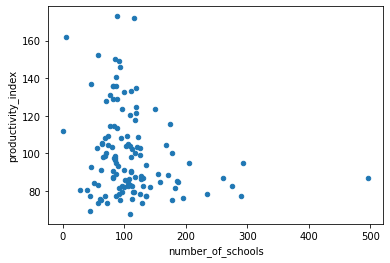

In [93]:
#scatter plot of data
schools_labour_prod.plot.scatter(x="number_of_schools", y="productivity_index")

# Line of Best Fit - # of Schools and Labour Productivity by Local Authority
There seems to be no real correlation between the number of schools in a local authority and its labour productivity up until the point at which the number of schools in a local authority exceeds 100

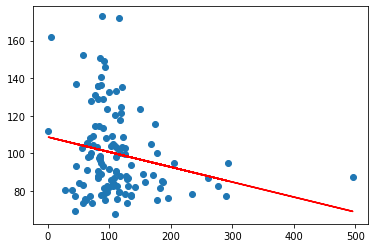

In [116]:
#perform some linear regression to find our line of best fit
#convert columns to numpy arrays
X = schools_labour_prod["number_of_schools"].to_numpy().reshape(-1,1)
Y = schools_labour_prod["productivity_index"].to_numpy().reshape(-1,1)

#instantiate linear regression object
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)

#show linear regression
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [117]:
r2_score(Y, Y_pred)

0.045723155018254635

# Let's control for population

I'll be adding the population for each local authority so we can derive a new "schools per capita" column to compare labour productivity with

In [101]:
#read in data from population dataset
population = pd.read_excel("ukpopestimatesmid2020on2021geography.xls", sheet_name="MYE4", header=6, skipfooter=7, skiprows=[5], usecols=[0,1,3])

#assign same column name for local authority code
population.rename(columns={"Code":"la_code", "Mid-2020":"Population"}, inplace=True)

population.head()

,la_code,Name,Population
0,K02000001,UNITED KINGDOM,67081234
1,K03000001,GREAT BRITAIN,65185724
2,K04000001,ENGLAND AND WALES,59719724
3,E92000001,ENGLAND,56550138
4,E12000001,NORTH EAST,2680763


In [125]:
#merge population and school_labour_prod datasets

schools_per_cap_labour_prod = pd.merge(schools_labour_prod, population, on='la_code')

#derive schools per capita column
schools_per_cap_labour_prod['schools_per_capita'] = schools_per_cap_labour_prod['number_of_schools'] / schools_per_cap_labour_prod['Population']

schools_per_cap_labour_prod

,la_code,la_name,number_of_schools,LAD Name,productivity_index,Name,Population,schools_per_capita
0,E08000010,Wigan,136,Wigan,77.16,Wigan,330712,0.000411
1,E06000054,Wiltshire,261,Wiltshire,86.98,Wiltshire,504070,0.000518
2,E09000011,Greenwich,105,Greenwich,109.37,Greenwich,289034,0.000363
3,E08000009,Trafford,103,Trafford,103.86,Trafford,237579,0.000434
4,E06000044,Portsmouth,66,Portsmouth,97.90,Portsmouth,214692,0.000307
...,...,...,...,...,...,...,...,...
118,E06000032,Luton,80,Luton,103.24,Luton,213528,0.000375
119,E08000022,North Tyneside,82,North Tyneside,90.45,North Tyneside,208871,0.000393
120,E06000035,Medway,110,Medway,103.96,Medway,279142,0.000394
121,E09000014,Haringey,100,Haringey,91.37,Haringey,266357,0.000375


# Scatter Plot - Schools per capita and Labour Productivity by Local Authority

<AxesSubplot:xlabel='schools_per_capita', ylabel='productivity_index'>

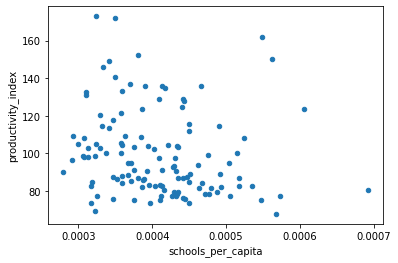

In [126]:
#Let's see if there is some correlation now

schools_per_cap_labour_prod.plot.scatter(x="schools_per_capita", y="productivity_index")

# Linear Regression - Schools per capita and Labour Productivity by Local Authority

Based on the R^2 score, schools per capita does not seem to be a determining factor for labour productivity for a certain area

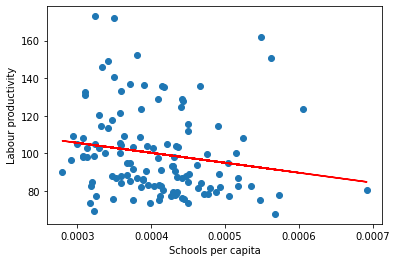

In [127]:
#perform some linear regression to find our line of best fit
#convert columns to numpy arrays
X = schools_per_cap_labour_prod["schools_per_capita"].to_numpy().reshape(-1,1)
Y = schools_per_cap_labour_prod["productivity_index"].to_numpy().reshape(-1,1)

#instantiate linear regression object
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)

#show linear regression
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("Schools per capita")
plt.ylabel("Labour productivity")
plt.show()

In [128]:
r2_score(Y, Y_pred)

0.029908559721389838

# Unemployment Rates and Schools per Capita

In [142]:
# Get data from unemployment excel file
unemployment = pd.read_excel("modelbasedunemploymentdata.xls", sheet_name="LA,UA Rates", header=2, skipfooter=9, skiprows=[3,4], usecols=[0,1,225])

unemployment.rename(columns={"Unnamed: 1":"la_code", "Jul 2020 to Jun 2021":"Unemployment Rate"}, inplace=True)
unemployment

,UALAD,la_code,Unemployment Rate
0,County Durham,E06000047,6.200000
1,Darlington,E06000005,5.802378
2,Hartlepool,E06000001,7.941371
3,Middlesbrough,E06000002,7.499282
4,Northumberland,E06000057,5.700000
...,...,...,...
365,South Ayrshire,S12000028,4.896814
366,South Lanarkshire,S12000029,4.421403
367,Stirling,S12000030,4.356094
368,West Dunbartonshire,S12000039,5.098213


In [146]:
# merge with schools and population datasets

unemployment_schools = pd.merge(schools, unemployment, on='la_code')
unemployment_schools_percap = pd.merge(unemployment_schools, population, on='la_code')

#add per capita column
unemployment_schools_percap['schools_per_capita'] = unemployment_schools_percap['number_of_schools'] / unemployment_schools_percap['Population']
unemployment_schools_percap.head()

,la_code,la_name,number_of_schools,UALAD,Unemployment Rate,Name,Population,schools_per_capita
0,E08000010,Wigan,136,Wigan,4.328324,Wigan,330712,0.000411
1,E06000054,Wiltshire,261,Wiltshire,3.100000,Wiltshire,504070,0.000518
2,E09000011,Greenwich,105,Greenwich,6.577925,Greenwich,289034,0.000363
3,E08000009,Trafford,103,Trafford,4.403807,Trafford,237579,0.000434
4,E06000044,Portsmouth,66,Portsmouth,5.196324,Portsmouth,214692,0.000307


# Scatter Plot - Schools per capita and Labour Productivity by Local Authority

<AxesSubplot:xlabel='schools_per_capita', ylabel='Unemployment Rate'>

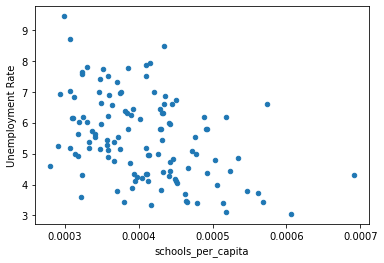

In [147]:
unemployment_schools_percap.plot.scatter(x="schools_per_capita", y="Unemployment Rate")

# Linear Regression - Schools per capita and Labour Productivity by Local Authority

There seems to actually be some level of correlation between the schools per capita in an area and the unemployment rate. The R^2 score is over 4 times higher

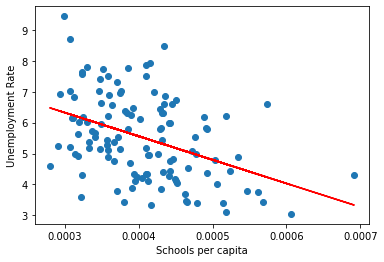

In [148]:
#perform some linear regression to find our line of best fit
#convert columns to numpy arrays
X = unemployment_schools_percap["schools_per_capita"].to_numpy().reshape(-1,1)
Y = unemployment_schools_percap["Unemployment Rate"].to_numpy().reshape(-1,1)

#instantiate linear regression object
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)

#show linear regression
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("Schools per capita")
plt.ylabel("Unemployment Rate")
plt.show()

In [149]:
r2_score(Y, Y_pred)

0.1729253195062107

# Crimes Reported per 1000 and Schools per Capita

In [199]:
# Get data from crimes reported excel file
crimes_reported = pd.read_excel("csptablejune21final.xlsx", sheet_name="Table C5", header=5, usecols=[4,5,8])

crimes_reported.rename(columns={"Local Authority code":"la_code", "Total recorded crime\n (excluding fraud)":"crimes_per_1000"}, inplace=True)
unemployment

crimes_reported = crimes_reported.dropna()

#remove rows with blank crimes recorded

crimes_reported = crimes_reported.query("crimes_per_1000 != '[x]' & crimes_per_1000 != '[u1]' ")

crimes_reported

,la_code,Local Authority name,crimes_per_1000
1,E06000022,Bath and North East Somerset,54.619902
2,E06000023,"Bristol, City of",104.448489
3,E06000024,North Somerset,62.410124
5,E06000025,South Gloucestershire,54.545265
8,E06000055,Bedford,81.637443
...,...,...,...
387,E08000034,Kirklees,93.124703
388,E08000035,Leeds,116.350312
390,E08000036,Wakefield,107.820997
392,E06000030,Swindon,66.23714


In [200]:
# Merge with schools and population dataframes
crime_reported_schools = pd.merge(schools, crimes_reported, on='la_code')
crime_reported_schools_percap = pd.merge(crime_reported_schools, population, on='la_code')

#add per capita column
crime_reported_schools_percap['schools_per_capita'] = crime_reported_schools_percap['number_of_schools'] / crime_reported_schools_percap['Population']
crime_reported_schools_percap



,la_code,la_name,number_of_schools,Local Authority name,crimes_per_1000,Name,Population,schools_per_capita
0,E06000054,Wiltshire,261,Wiltshire,46.451882,Wiltshire,504070,0.000518
1,E09000011,Greenwich,105,Greenwich,89.089865,Greenwich,289034,0.000363
2,E06000044,Portsmouth,66,Portsmouth,114.144915,Portsmouth,214692,0.000307
3,E06000052,Cornwall,290,Cornwall,47.530172,Cornwall,573299,0.000506
4,E06000031,Peterborough,83,Peterborough,101.206163,Peterborough,202626,0.000410
...,...,...,...,...,...,...,...,...
105,E06000032,Luton,80,Luton,86.452362,Luton,213528,0.000375
106,E08000022,North Tyneside,82,North Tyneside,85.976512,North Tyneside,208871,0.000393
107,E06000035,Medway,110,Medway,109.990614,Medway,279142,0.000394
108,E09000014,Haringey,100,Haringey,107.277076,Haringey,266357,0.000375


# Scatter Plot - Schools per capita and Crimes Reported per 1000

<AxesSubplot:xlabel='schools_per_capita', ylabel='crimes_per_1000'>

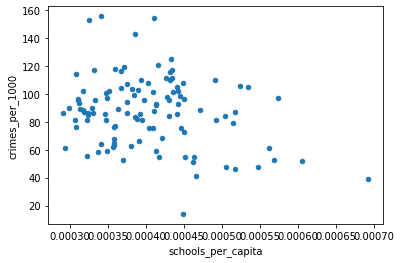

In [204]:
crime_reported_schools_percap.plot.scatter(x="schools_per_capita", y="crimes_per_1000")

# Linear Regression - Schools per capita and Crimes Reported per 1000

There seems to be a mild correlation between schools per capita and crimes reported per 1000

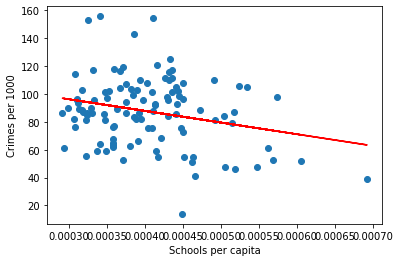

In [207]:
#perform some linear regression to find our line of best fit
#convert columns to numpy arrays
X = crime_reported_schools_percap["schools_per_capita"].to_numpy().reshape(-1,1)
Y = crime_reported_schools_percap["crimes_per_1000"].to_numpy().reshape(-1,1)

#instantiate linear regression object
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)

#show linear regression
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("Schools per capita")
plt.ylabel("Crimes per 1000")
plt.show()

In [208]:
r2_score(Y, Y_pred)

0.06366610658002914